In [2]:
Author: Lingfei Wu
%matplotlib inline
import sys
from collections import defaultdict, Counter
import networkx as nx
import numpy as np
import pylab as plt
import torch as th
import json
import math
#import matplotlib.cm as cm
import statsmodels.api as sm
from os import listdir
from scipy.stats.stats import pearsonr
import json
import random
import itertools
from copy import deepcopy
import time
import scipy as sp
from scipy.sparse import csr_matrix
import matplotlib.cm as cm
from numpy.random import choice
import itertools
from sklearn import manifold
import operator
import itertools
from datetime import datetime as dt
import matplotlib.mlab as mlab
from scipy.stats import norm
import re
from scipy import stats
from scipy.spatial import Voronoi
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats.mstats import zscore

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    sys.stdout.write(d)
    sys.stdout.flush()

def DiffusionWeightAverage(threshold,data):#[value,samplesize] in data
    smoothData=[data[0]]
    for n,j in enumerate(data[1:]):
        value,sampleSize=j
        if sampleSize<threshold:
            lastValue,lastSampleSize=smoothData[n-1]
            value=np.average([lastValue,value], weights=[lastSampleSize, sampleSize])
        smoothData.append([value,sampleSize])
    return smoothData

def OLSRegressFit(x,y):
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    return [constant,beta] 

def clean(s): return re.sub('[^A-Za-z0-9]+', ' ', s).strip().lower()

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return phi,rho

# Embedding 

In [50]:
def getData(path,fb):
    pt = th.load(path)
    pos=dict(zip(pt['objects'],pt['model']['lt.weight'].numpy()))
    posP=dict((i,cart2pol(*pos[i])) for i in pos)
    ks=np.array([fb[s] for s in posP])*10000+1
    return posP,ks

## Top 1000 skills from Publications, Jobs, and Courses

In [4]:
top1000=[]
fb={}
fo={}
fw={}
with open('PubllicationTop1000.txt', 'rb') as f:
    for line in f:
        s,b,o,w=line.strip().split('\t')
        top1000.append(s)
        fb[s]=float(b)
        fo[s]=float(o)
        fw[s]=float(w)

In [51]:
Eb={}
with open("JobsTop10000.tsv", 'rb') as f:
    for line in f:
        i,j,w=line.strip().split('\t')
        Eb[(i,j)]=int(w)/(2*6199739000.0)
Eo={}
with open("CoursesTop10000.tsv", 'rb') as f:
    for line in f:
        i,j,w=line.strip().split('\t')
        Eo[(i,j)]=int(w)/(2*112377820.0)
Ew={}
with open("PublicationsTop10000.tsv", 'rb') as f:
    for line in f:
        i,j,w=line.strip().split('\t')
        Ew[(i,j)]=int(w)/(2*69275242.0)

In [53]:
topb=zip(*sorted(fb.items(),key=lambda x:-x[1])[:20])[0]
topo=zip(*sorted(fo.items(),key=lambda x:-x[1])[:20])[0]
topw=zip(*sorted(fw.items(),key=lambda x:-x[1])[:20])[0]

In [59]:
hard=['r','experiments','spect','simulation',
     'optimization','therapy','vtam','proteins','vs','history',
     'dna','scanning','surgery','sql','python','java','apache hadoop','machine learning',
      'mathematics','big data','data mining','data analysis','sas',
      'statistics']
soft=['research','management','communication skills','team work/ Collaboration',
     'problem solving','writing']
hard=[i for i in hard if i in posPb and i in posPo and i in posPw ]
soft=[i for i in soft if i in posPb and i in posPo and i in posPw ]

In [60]:
Red = '#de2d26'
Green = '#006d2c'
Blue = '#3182bd'
SoftColor = '#fd8d3c'
HardColor = '#810f7c'
Font = 'Lato'

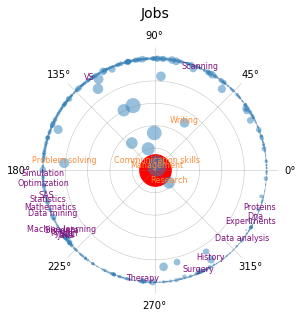

In [66]:
fig = plt.figure(figsize=(15, 5))
#cmap = cm.get_cmap('rainbow_r',10)
ax = fig.add_subplot(131, projection='polar')
embeddingP = np.array([posPb.values()]).T
ax.scatter(embeddingP[0], embeddingP[1],c=Blue,
           s=ksb,linewidth=0,alpha=0.5,zorder=2)
for i in soft:
    phi,rho=posPb[i]
    plt.text(phi,rho,i[0].upper()+i[1:],ha='center',color=SoftColor,size=8,zorder=3)
for i in hard:
    phi,rho=posPb[i]
    if i in ['vs','sas','sql']:
        plt.text(phi,rho,i.upper(),ha='center',color=HardColor,size=8,zorder=3)
    else:
        plt.text(phi,rho,i[0].upper()+i[1:],ha='center',color=HardColor,size=8,zorder=3)
plt.scatter(0,0,1000,color='r')
ax.set_rmax(1.1)
ax.set_yticklabels('')
ax.yaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
ax.spines['polar'].set_visible(False)
ax.xaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
plt.title('Jobs',size=14,y=1.1)
ax.set_rlabel_position(0)

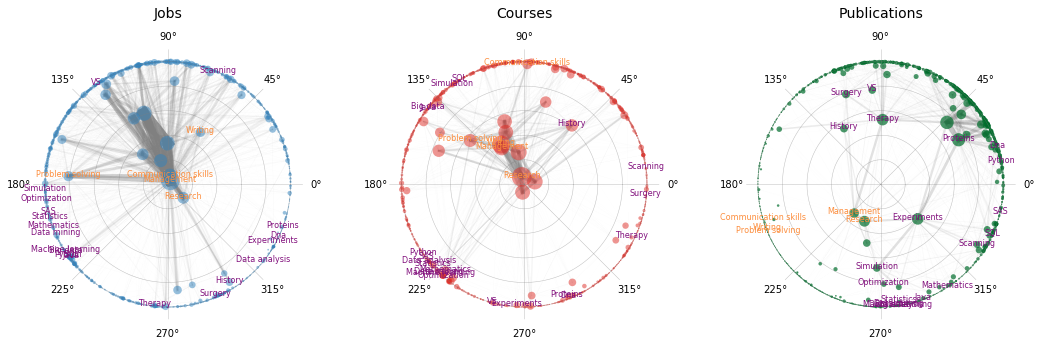

In [68]:
plt.rcParams['svg.fonttype'] = 'none'
np.seterr(divide='ignore', invalid='ignore') # to remove warning messages
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131, projection='polar')
embeddingP = np.array([posPb.values()]).T
ax.scatter(embeddingP[0], embeddingP[1],c=Blue,
           s=ksb,linewidth=0,alpha=0.5,zorder=2)
for i in soft:
    phi,rho=posPb[i]
    plt.text(phi,rho,i[0].upper()+i[1:],ha='center',color=SoftColor,size=8,zorder=3)
for i in hard:
    phi,rho=posPb[i]
    if i in ['vs','sas','sql']:
        plt.text(phi,rho,i.upper(),ha='center',color=HardColor,size=8,zorder=3)
    else:
        plt.text(phi,rho,i[0].upper()+i[1:],ha='center',color=HardColor,size=8,zorder=3)
for k,v in Eb.items():
    i,j=k
    if v>0.00001:
        xi,yi=posPb[i]
        xj,yj=posPb[j]
        plt.plot([xi,xj],[yi,yj],color='gray',alpha=v*500,linewidth=v*10000,zorder=1)
ax.set_rmax(1.1)
ax.set_yticklabels('')
ax.yaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
ax.spines['polar'].set_visible(False)
ax.xaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
plt.title('Jobs',size=14,y=1.1)
ax.set_rlabel_position(0)
#
ax = fig.add_subplot(132, projection='polar')
embeddingP = np.array([posPo.values()]).T
ax.scatter(embeddingP[0], embeddingP[1],c=Red,
           s=kso,linewidth=0,alpha=0.5,zorder=2)
for i in soft:
    phi,rho=posPo[i]
    plt.text(phi,rho,i[0].upper()+i[1:],ha='center',color=SoftColor,size=8,zorder=3)
for i in hard:
    phi,rho=posPo[i]
    if i in ['vs','sas','sql']:
        plt.text(phi,rho,i.upper(),ha='center',color=HardColor,size=8,zorder=3)
    else:
        plt.text(phi,rho,i[0].upper()+i[1:],ha='center',color=HardColor,size=8,zorder=3)
for k,v in Eo.items():
    i,j=k
    if v>0.00001:
        xi,yi=posPo[i]
        xj,yj=posPo[j]
        plt.plot([xi,xj],[yi,yj],color='gray',alpha=v*500,linewidth=v*10000,zorder=1)
ax.set_rmax(1.1)
ax.set_yticklabels('')
ax.yaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
ax.spines['polar'].set_visible(False)
ax.xaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
plt.title('Courses',size=14,y=1.1)
ax.set_rlabel_position(0)
#
ax = fig.add_subplot(133, projection='polar')
embeddingP = np.array([posPw.values()]).T
ax.scatter(embeddingP[0], embeddingP[1],c=Green,
           s=ksw,linewidth=0,alpha=0.7,zorder=2)
for i in soft:
    phi,rho=posPw[i]
    plt.text(phi,rho,i[0].upper()+i[1:],ha='center',color=SoftColor,size=8,zorder=3)
for i in hard:
    phi,rho=posPw[i]
    if i in ['vs','sas','sql']:
        plt.text(phi,rho,i.upper(),ha='center',color=HardColor,size=8,zorder=3)
    else:
        plt.text(phi,rho,i[0].upper()+i[1:],ha='center',color=HardColor,size=8,zorder=3)
for k,v in Ew.items():
    i,j=k
    if v>0.00001:
        xi,yi=posPw[i]
        xj,yj=posPw[j]
        plt.plot([xi,xj],[yi,yj],color='gray',alpha=v*500,linewidth=v*10000,zorder=1)
ax.set_rmax(1.1)
ax.set_yticklabels('')
ax.yaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
ax.spines['polar'].set_visible(False)
ax.xaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
plt.title('Publications',size=14,y=1.1)
ax.set_rlabel_position(0)
#
plt.tight_layout()
plt.subplots_adjust(top=0.85,bottom = 0.1)
#plt.savefig('/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/hyperNew.svg')
plt.savefig('/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/hyperNew.pdf')